In [7]:
# Importing necessary libraries

%matplotlib inline

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns



In [8]:
# Loading in gene/TF expression (pocket) data and checking dimensions

gene_expression = pd.read_csv(('/Users/christianlangridge/Desktop/Zhang-Lab/Zhang Lab Data/Pocket data files/Geneexpression(pocket).tsv'), sep='\t', header=0)
gene_expression.shape



(4892, 3960)

In [9]:
tf_expression = pd.read_csv(('/Users/christianlangridge/Desktop/Zhang-Lab/Zhang Lab Data/Pocket data files/TF(pocket).tsv'), sep='\t', header=0)
tf_expression.shape

(4892, 208)

In [10]:
# Spit into training, testing and validation sets and into numpy arrays + combining dataframes
x = tf_expression
y = gene_expression

combined_data = pd.concat([x, y], axis=1)

# First split: 70% train and 30% temp (test + val)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42)

# Second split: split the temp set into 20% test and 10% val (which is 2/3 and 1/3 of temp)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=1/3, random_state=42)


# For training set
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

# For validation set
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()

# For testing set
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape


((3424, 208), (978, 208), (490, 208), (3424, 3960), (978, 3960), (490, 3960))

In [11]:
# Generating the model for multiple linear regression with ordinary least squares on all data and print out R² value 
# Very little predictive power for TF expression on gene expression in pocket data (R² = 0.144)

reg_test = LinearRegression().fit(x, y)
print('Score: ', reg_test.score(x, y))


Score:  0.14422363800123678


In [ ]:
#Visualisation of fit line over each datapoint
#Regplot inputs are multidimensional and need to reshape to be 1D to actually plot them (hence the error) 

x_line = np.arange(5,25).reshape(-1,1)
sns.regplot(x=x, y=y, data=combined_data, fit_reg=False)
plt.plot(x_line, reg_test.predict(x_line))
plt.show()

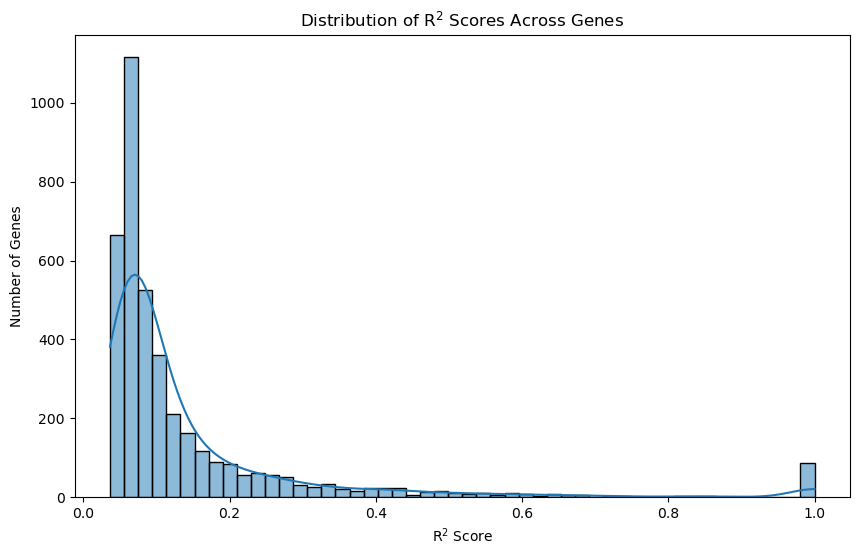

/var/folders/cm/2qsqsrsd3p1d2cy6d02rgs8m0000gn/T/ipykernel_12485/1771801396.py:30: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=coef_df, inner='quartile', scale='width')


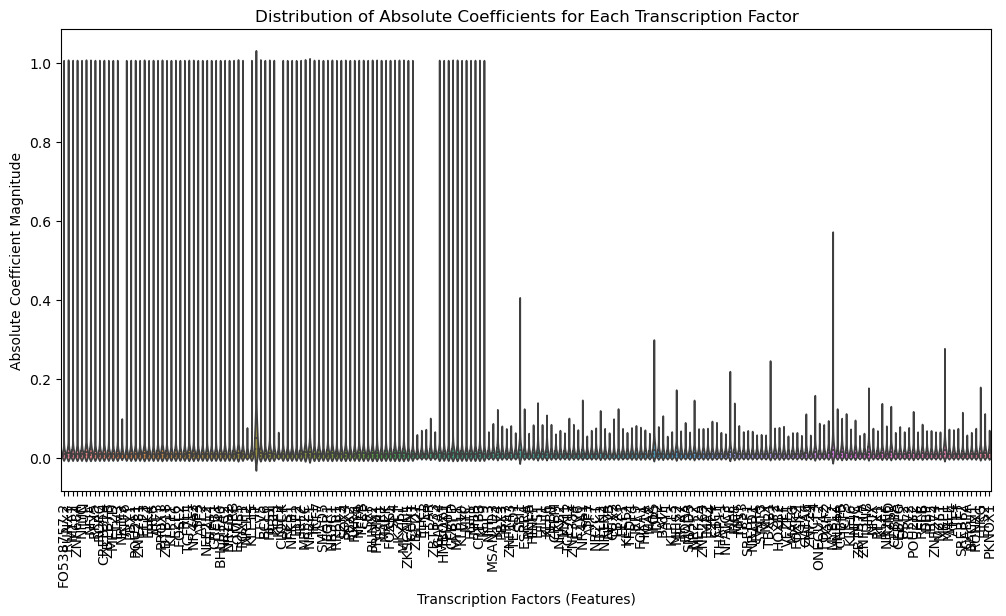

In [ ]:
# Evaluating model performance across all genes and plotting R² distribution and coefficient magnitudes

n_genes = y.shape[1]
r2_scores = np.zeros(n_genes)
coef_magnitudes = np.zeros((n_genes, x.shape[1]))

for i in range(n_genes):
    y_gene = y.iloc[:, i].values  # Target expression for gene i
    model = LinearRegression().fit(x.values, y_gene)
    
    r2_scores[i] = model.score(x.values, y_gene)
    coef_magnitudes[i, :] = np.abs(model.coef_)

# Convert to DataFrame for easier plotting
r2_df = pd.DataFrame({'Gene': y.columns, 'R2': r2_scores})
coef_df = pd.DataFrame(coef_magnitudes, columns=x.columns)

# Plot R^2 distribution

plt.figure(figsize=(10,6))
sns.histplot(r2_df['R2'], bins=50, kde=True)
plt.title('Distribution of R$^2$ Scores Across Genes')
plt.xlabel('R$^2$ Score')
plt.ylabel('Number of Genes')
plt.show()

# Plot coefficient magnitude distribution as a violin plot 

plt.figure(figsize=(12,6))
sns.violinplot(data=coef_df, inner='quartile', scale='width')
plt.xticks(rotation=90)
plt.title('Distribution of Absolute Coefficients for Each Transcription Factor')
plt.ylabel('Absolute Coefficient Magnitude')
plt.xlabel('Transcription Factors (Features)')
plt.show()


In [ ]:
# Implementing some SHAP analysis for MLR explanability

import shap
shap.initjs()

explainer = shap.LinearExplainer(reg_test, x_train)
shap_values = explainer.shap_values(x_train)